# Neural circuit dynamics underlying accumulation of time-varying evidence during perceptual decision making

Kong-Fatt Wong1, Alexander C. Huk2, Michael N. Shadlen3 and Xiao-Jing Wang4*


Front. Comput. Neurosci., 02 November 2007 | https://doi.org/10.3389/neuro.10.006.2007


### The two-variable network model

### Calling Library Fuctions

In [1]:
# LIBRARY

import numpy as np # vector manipulation
import math  # math functions
import sys

# THIS IS FOR PLOTTING
%matplotlib inline
import matplotlib.pyplot as plt # side-stepping mpl backend
import warnings
warnings.filterwarnings("ignore")


### The Reduced Network Model

$$r_i=f(I_i)=\frac{aI_i-b}{1-exp[-d(aI_i-b])}$$

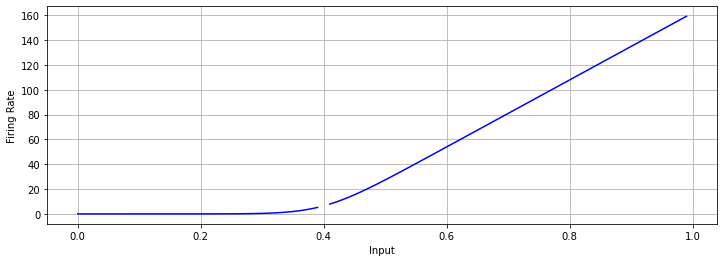

In [2]:
def H(x):
    a=270 # Hz/nA
    b=108 # Hz
    d=.154 # seconds
    f=(a*x-b)/(1-np.exp(-d*(a*x-b)))
    return f
x=np.arange(0,1,0.01)
fig = plt.figure(figsize=(12,4))

plt.plot(x,H(x),'-',color='blue')
plt.xlabel('Input')
plt.ylabel('Firing Rate')
plt.grid()
plt.show()

### Neural Circuit
$$ x_{1}=J_{11}S_1-J_{12}S_2+I_{0}+I_{1}+I_{noise,1}$$
$$ x_{2}=J_{22}S_2-J_{21}S_1+I_{0}+I_{2}+I_{noise,1}$$

where the synaptic couplings are $J_{11}=0.2609$, $J_{22}=0.2609$, $J_{12}=0.0497$ and $J_{21}=0.0497$.
$I_{0}=0.3255 nA$ represents external input 


In [3]:
def total_synaptic_current(S_1,S_2,I_1,I_2,I_noise_1,I_noise_2):
    # Synaptic coupling
    J_11=0.2609 # nA
    J_22=0.2609 # nA
    J_12=0.0497 # nA
    J_21=0.0497 # nA
    I_0=0.3255  # nA
    x_1=J_11*S_1-J_12*S_2+I_0+I_1+I_noise_1
    x_2=J_22*S_2-J_21*S_1+I_0+I_2+I_noise_2
    return x_1, x_2


### Background activity
$$ \tau_{noise}\frac{d I_{noise,i}(t)}{dt} =-(I_{noise,i}(t)-I_0)+\eta_i(t)\sqrt{\tau_{noise}}\sigma_{noise}$$
with a mean backgroud input $I_0=0.3297$, white noise $\eta(t_j)$ noise amplitude $\sigma_{noise}=0.009$ nA and fitler time constant $\tau_{noise}=2$ms.
The solution to the equation is approximated used the forward Euler method giving the difference equation
$$ I_{noise,j+1}=I_{noise,j}+\frac{h}{\tau_{noise}}(-(I_{noise,j}-I_0)+\eta_{j}\sqrt{\tau_{noise}}\sigma_{noise} $$
where $h$ is the time step.

In [4]:
def Background_Activity(I_noise):
    h=0.1/1000
    sigma_noise=0.02 # nA
    tau_AMPA=2 #ms
    eta_noise=0.1*np.random.uniform(0,1,1)
    k=(-(I_noise)+eta_noise*np.sqrt(tau_AMPA)*sigma_noise)
    I_noise_new=I_noise+h/tau_AMPA*(-(I_noise+h/2*k)+eta_noise
                                *np.sqrt(tau_AMPA)*sigma_noise)
    return I_noise_new

### Network Dynamics
The network dynamics is dominated by $S_i$ model by the first order problem:
$$ \frac{d S_{i}}{dt} =-\frac{S_{i}}{\tau_S}+(1-S_{i})\gamma f(I)$$
where $\gamma=0.641$ and $\tau_s=60$ms. 
The solution to the equation is approximated used the forward Euler method giving the difference equation
$$ S_{i,j+1}=S_{i,j}+h\left(-\frac{S_{i,j}}{\tau_S}+(1-S_{i,j}\gamma f(I_i) \right)$$
where $h$ is the time step.

In [5]:
def Network_Dynamics(S,x):
    h=0.1/1000 #ms
    gamma=0.641
    tau_S=.10 #s
    k=(-S/tau_S+(1-S)*gamma*H(x)/1)
    S_new=S+h*(-(S+h/2*k)/tau_S+(1-S+h/2*k)*gamma*H(x))
    return S_new




### Right Input Current Target

$$ I_i=J_{A,ext}\mu_0\left(1+ \frac{c'}{100} \right) $$


In [6]:
def I_input_1(c_dash):
    J_A_ext=5.2/10000 # nA/Hz
    mu_0=30 # Hz
    I_motion=J_A_ext*mu_0*(1+(c_dash)/100)
    return I_motion

### Left Input Current Target

$$ I_2=J_{A,ext}\mu_0\left(1- \frac{c'}{100} \right) $$

In [7]:
def I_input_2(c_dash):
    J_A_ext=0.00052 # nA/Hz
    mu_0=30 # Hz
    I_motion=J_A_ext*mu_0*(1-(c_dash)/100)
    return I_motion

In [8]:
h=0.1
time=np.arange(-100,1500,h)
J_A_ext=0.00052 # nA/Hz
mu_0=30 # Hz

In [9]:
COHERENCE_LEVEL=20
N=100
count=0
BOUND=15

In [10]:
ANSWER=np.zeros(N)
RT=np.zeros(N)
ALL_S_1=0.2*np.ones((N,len(time)))
ALL_S_2=0.2*np.ones((N,len(time)))
ALL_F_1=0.2*np.ones((N,len(time)))
ALL_F_2=0.2*np.ones((N,len(time)))
for n in range(0,N):
    I_noise_1=0.001*np.random.normal(0,1,len(time))
    I_noise_2=0.001*np.random.normal(0,1,len(time))

    x_1=0*J_A_ext*mu_0*np.random.uniform(0,1,len(time))
    x_2=0*J_A_ext*mu_0*np.random.uniform(0,1,len(time))

    S_1=0.2*np.ones(len(time))+0.01*np.random.normal(0,1,len(time))#0.1*np.random.uniform(0,1,len(time))# np.random.normal(0,1,len(time))*0.0004
    S_2=0.2*np.ones(len(time))+0.01*np.random.normal(0,1,len(time)) #0.1*np.random.uniform(0,1,len(time)) #np.random.normal(0,1,len(time))*0.0004

    I_1=0.0*np.ones(len(time)) # np.zeros((1,len(time)))
    I_2=0.0*np.ones(len(time)) # np.zeros((1,len(time)))
    Firing_target_1=0*time # np.zeros((1,len(time)))
    Firing_target_2=0*time # np.zeros((1,len(time)))

    if n%25==0:
        print(n)
    count=0
    for i in range (0,len(time)-1):
        if time[i] >=0 and time[i]<1000:
            c_dash=COHERENCE_LEVEL
        else:
            c_dash=0.0


        Firing_target_1[i]=H(x_1[i])
        Firing_target_2[i]=H(x_2[i])

       # I_noise_1[i+1]=0.0*Background_Activity(I_noise_1[i])
        # I_noise_2[i+1]=0.0*Background_Activity(I_noise_2[i])

        I_1[i+1]=I_input_1(c_dash)
        I_2[i+1]=I_input_1(-c_dash)

        x_1[i+1],x_2[i+1]=total_synaptic_current(S_1[i],S_2[i],I_1[i],I_2[i],I_noise_1[i],I_noise_2[i])
        S_1[i+1]=Network_Dynamics(S_1[i],x_1[i+1])
        S_2[i+1]=Network_Dynamics(S_2[i],x_2[i+1])
        if count <0.5:
            if Firing_target_1[i] >=BOUND: 
                ANSWER[n]=0 
                RT[n]=time[i]
                count=1
            elif Firing_target_2[i] >=BOUND:
                ANSWER[n]=1
                RT[n]=time[i]
                count=1
    ALL_F_1[n,:]=Firing_target_1
    ALL_F_2[n,:]=Firing_target_2
    ALL_S_1[n,:]=Firing_target_1
    ALL_S_2[n,:]=Firing_target_2

0
25
50
75


### Plotting
The top plot shows the input to the left (red) and right (blue) areas.
The middle plot is the output, S, for the (red) and right (blue) areas.
The bottom plot is the firing rate for the (red) and right (blue) areas.

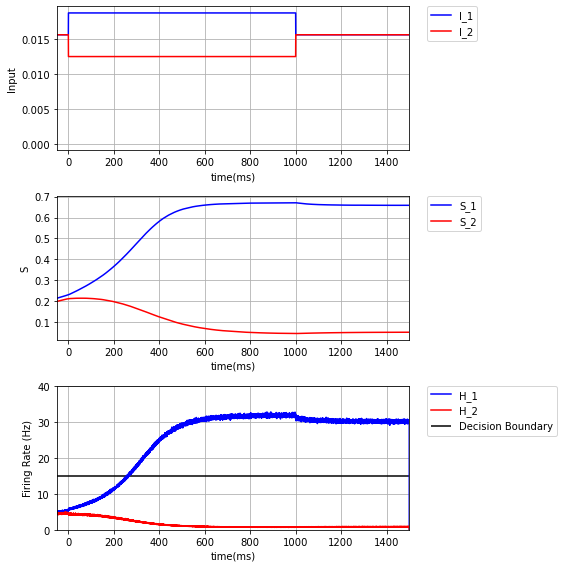

In [11]:
fig = plt.figure(figsize=(8,8))
## INPUT
plt.subplot(311)
plt.plot(time,I_1,'-',color='blue',label="I_1")
plt.plot(time,I_2,'-',color='red',label="I_2")
plt.grid()
plt.xlabel('time(ms)')
plt.ylabel('Input')
plt.xlim((-50,1500))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## ACTIVITY
plt.subplot(312)
plt.plot(time,S_1,'-',color='blue',label="S_1")
plt.plot(time,S_2,'-',color='red',label="S_2")
plt.grid()
plt.xlim((-50,1500))
plt.xlabel('time(ms)')
plt.ylabel('S')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# NEURONAL FIRING ACTIVITY
plt.subplot(313)
plt.plot(time,Firing_target_1,'-',color='blue',label="H_1")
plt.plot(time,Firing_target_2,'-',color='red',label="H_2")
plt.hlines(BOUND,-100,1500,label='Decision Boundary',color='k')

plt.grid()
plt.xlabel('time(ms)')
plt.ylabel('Firing Rate (Hz)')
plt.xlim((-50,1500))
plt.ylim((0,40))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


# plt.
#plt.ylim((30,50))
plt.tight_layout()
plt.show()


## Left and Right Firing Rates

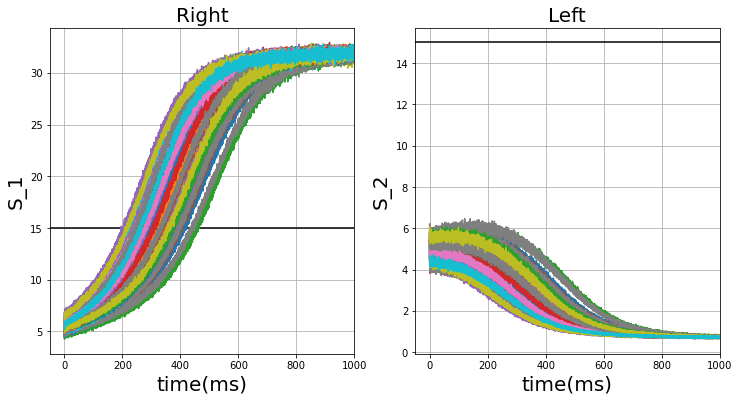

In [12]:
fig = plt.figure(figsize=(12,6))
plt.subplot(121)
for n in range(0,N):
    plt.plot(time[1000:15000],ALL_S_1[n,1000:15000],'-')
plt.grid()
plt.xlim((-50,1000))
plt.xlabel('time(ms)', color='k', size=20)
plt.ylabel('S_1', color='k', size=20)
plt.hlines(BOUND,-100,1500,label='Decision Boundary',color='k')
plt.title('Right', color='k', size=20)
plt.subplot(122)
for n in range(0,N):
    plt.plot(time[1000:15000],ALL_S_2[n,1000:15000],'-')
plt.grid()
plt.xlim((-50,1000))
plt.xlabel('time(ms)', color='k', size=20)
plt.hlines(BOUND,-100,1500,label='Decision Boundary',color='k')
plt.ylabel('S_2', color='k', size=20)
plt.title('Left', color='k', size=20)
plt.show()

# Reaction Time

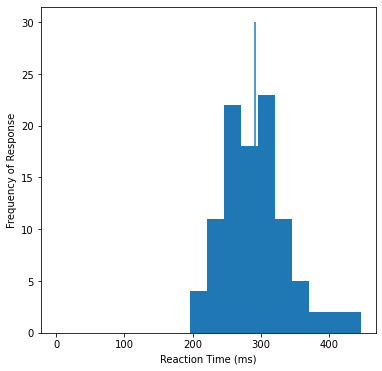

In [13]:
fig = plt.figure(figsize=(6,6))
plt.hist(RT[ANSWER==0])
plt.hist(RT[ANSWER==1],color="red")
plt.vlines(np.average(RT[ANSWER==1]),0,30,color="red")
plt.vlines(np.average(RT[ANSWER==0]),0,30)
plt.xlabel('Reaction Time (ms)')
plt.ylabel('Frequency of Response')
plt.show()

# Number of responses


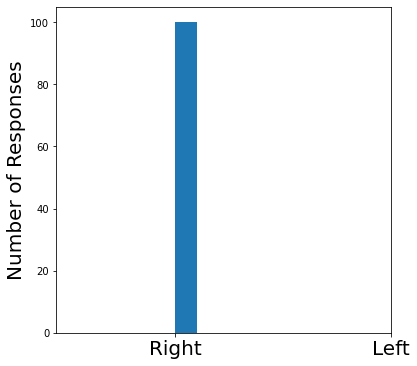

In [14]:
fig = plt.figure(figsize=(6,6))
plt.hist(ANSWER)
plt.xticks((0, 1), ('Right', 'Left'), color='k', size=20)
plt.ylabel('Number of Responses', color='k', size=20)
plt.show()

# Phase Plane plot
The figure below plots the 
Blue is right decisions

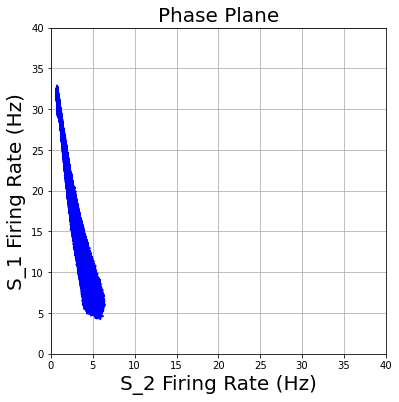

In [15]:
fig = plt.figure(figsize=(6,6))
for n in range(0,N):
    if ANSWER[n]==0:
        plt.plot(ALL_S_2[n,1000:15000],ALL_S_1[n,1000:15000],'-',color='blue')
    else:
        plt.plot(ALL_S_2[n,1000:15000],ALL_S_1[n,1000:15000],'-',color='red')

        #plt.plot(S_2,S_1,'-',color='blue',label="S_1")
plt.grid()
plt.xlabel('S_2 Firing Rate (Hz)', color='k', size=20)
plt.ylabel('S_1 Firing Rate (Hz)', color='k', size=20)
plt.xlim((0,40))
plt.ylim((0,40))
plt.title('Phase Plane', color='k', size=20)
plt.show()